In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from shapely.geometry import Point
from sklearn.metrics.pairwise import euclidean_distances

In [18]:
ssf_tracts = [
    '6001P',
    '6017',
    '6018P',
    '6018',
    '6019',
    '6019.01',
    '6019.02',
    '6020P',
    '6020.01',
    '6020.02',
    '6021',
    '6022',
    '6022.02',
    '6022.01',
    '6023P',
    '6024P',
    '6024',
    '6025',
    '6026',
    '6026.01',
    '6026.02',
    '6038.01',
    '6038.02',
    '6039',
    '6040',
    '6041.02P',
    '6041.03',
    '6041.04',
    '6042P'
]
sb_tracts = [
    '6023P',
    '6030P',
    '6035P',
    '6036P',
    '6037',
    '6038P',
    '6039P',
    '6040',
    '6041.01P',
    '6041.02P',
    '6042P',
    '6046P',
    '6135.01P'
]

other_tracts = [
    '6016.01',
    '6027',
    '6140',
    '6016.03',
    '6016.05'
]

tracts = ssf_tracts + sb_tracts + other_tracts

# Tracts in the shapefile don't contain 'P'
reformat = lambda tract: tract.replace('P', '')
tracts_reformatted = list(map(reformat, tracts))

In [19]:
census_tracts = gpd.read_file('../shapefiles/tl_2024_06_tract.shp')
census_tracts['NAME'] = census_tracts['NAME'].astype(str)

In [20]:
ssf_sb_tracts = census_tracts[(census_tracts['COUNTYFP'] == '081') & census_tracts['NAME'].isin(tracts_reformatted)]

In [21]:
daily_asds = gpd.read_file('../data/Daily ASDS 2018-2023 for South San Francisco San Bruno.csv')
hourly_asds = gpd.read_file('../data/Hourly ASDS 2018-2023 for South San Francisco San Bruno.csv')

In [22]:
metadata = gpd.read_file('../data/ASDS 2018-2023 for South San Francisco and San Bruno Metadata.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

(37.6, 37.7)

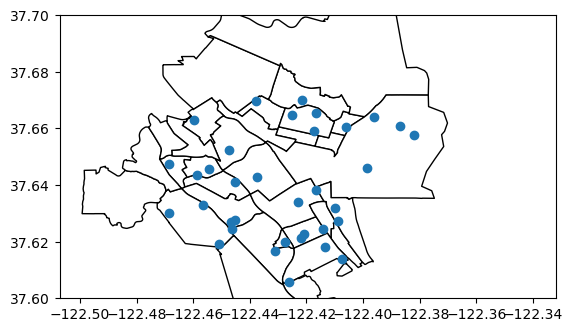

In [23]:
base = ssf_sb_tracts.plot(edgecolor='black', color='white')
metadata.plot(ax=base)
base.set_ylim([37.60,37.70])

In [24]:
health_ins_coverage = gpd.read_file('../data/ACSST5Y2023.S2701-Data.csv')[1:]

In [25]:
ex_tract = lambda name: name.split('Census Tract')[-1].split(';')[0].strip()
health_ins_coverage['NAME'] = health_ins_coverage['NAME'].apply(ex_tract).astype(str)
health_ins_coverage['S2701_C05_001E'] = health_ins_coverage['S2701_C05_001E'].astype(float)

In [26]:
ins_mapping = ssf_sb_tracts.join(health_ins_coverage.set_index('NAME')[['S2701_C05_001E']], on='NAME')

<Axes: >

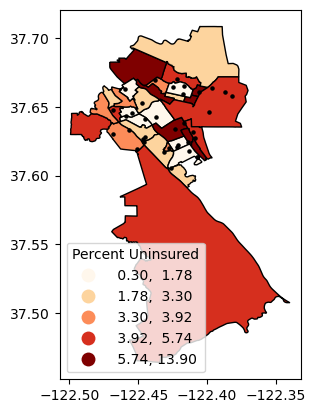

In [27]:
base = ins_mapping.plot(
    column='S2701_C05_001E', 
    edgecolor='black',
    cmap='OrRd',
    legend=True,
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'red',
        'hatch': '///',
        'label': 'No data'
    },
    legend_kwds={'title': 'Percent Uninsured'},
    scheme='quantiles'
)
metadata.plot(ax=base, color='black', markersize=5)

In [28]:
def manual_tofloat(val):
    try:
        return float(val)
    except Exception:
        return float('NaN')

In [29]:
hourly_asds['PM2.5_EPA'] = hourly_asds['PM2.5_EPA'].apply(manual_tofloat)

In [30]:
hourly_asds_pivot = hourly_asds.pivot(index='Datetime', columns='Site_ID', values='PM2.5_EPA')

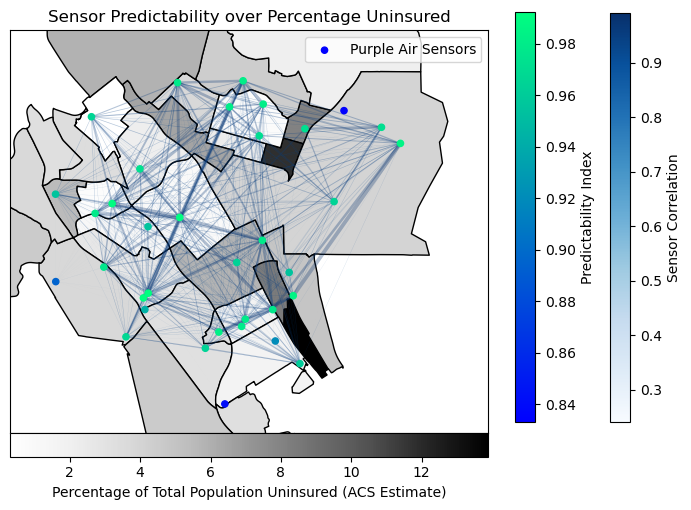

In [84]:
import matplotlib.colors as mcolors

sensor_corrs = hourly_asds_pivot.corr(method='pearson')

base = ins_mapping
coords = np.array([list(point.coords)[0] for point in metadata.geometry])

corr_threshold = 0

G = nx.Graph()

# Add nodes (points)
for i, point in enumerate(metadata.geometry):
    G.add_node(i, pos=(point.x, point.y))

predictability = []
# Add edges (correlations based on distance)
for i in range(len(metadata)):
    sensor_i = metadata['Site_ID'][i]
    sensor_i_corrs = sensor_corrs[sensor_i]
    
    for j in range(i + 1, len(metadata)):
        sensor_j = metadata['Site_ID'][j]
        corr = sensor_i_corrs[sensor_j]            
        
        if corr == corr and abs(corr) > corr_threshold:
            G.add_edge(i, j, weight=corr)
        
    predictability.append(sensor_i_corrs[sensor_i_corrs.index != sensor_i].max())
    
# Step 4: Set the position for each node based on its geographical coordinates
pos = {i: (metadata.geometry[i].x, metadata.geometry[i].y) for i in range(len(metadata))}

# Step 5: Plot the map with GeoPandas and add the network

fig, ax = plt.subplots(figsize=(8, 8))

tract_cmap_str = 'Greys'
# Plot base map (you can use any geopandas dataframe that represents geographical boundaries)
base.plot(
    column='S2701_C05_001E', 
    edgecolor='black',
    cmap=plt.cm.Greys,
    markersize=3,
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'red',
        'hatch': '///',
        'label': 'No data'
    },
    ax=ax
)

# Plot the points (nodes of the network)
#metadata.plot(ax=ax, color='red', markersize=50, label='Sensors')

edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
edge_width = list(map(lambda w: 5*w**40, weights))
edge_cmap = plt.cm.Blues
node_cmap = plt.cm.winter
tract_cmap = plt.cm.Greys

edges_sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=mcolors.Normalize(vmin=min(weights), vmax=max(weights)))
edges_sm.set_array([])
fig.colorbar(edges_sm, ax=ax, orientation="vertical", label="Sensor Correlation", fraction=0.033, pad=0.12)

nodes_sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=mcolors.Normalize(vmin=min(predictability), vmax=max(predictability)))
nodes_sm.set_array([])
fig.colorbar(nodes_sm, ax=ax, orientation="vertical", label="Predictability Index", fraction=0.039)

tract_sm = plt.cm.ScalarMappable(cmap=tract_cmap, norm=mcolors.Normalize(vmin=ins_mapping['S2701_C05_001E'].min(), vmax=ins_mapping['S2701_C05_001E'].max()))
tract_sm.set_array([])
fig.colorbar(tract_sm, ax=ax, orientation="horizontal", label="Percentage of Total Population Uninsured (ACS Estimate)", pad=0.0)

# Plot the edges (connections between points)
nx.draw_networkx_edges(G, pos, ax=ax, edge_color=weights, width=edge_width, alpha=0.3, edge_cmap=edge_cmap)

# Plot the nodes (points) on top of the map
nx.draw_networkx_nodes(G, pos, ax=ax, node_color=predictability, node_size=20, label='Purple Air Sensors', cmap=node_cmap)

# Customize plot
ax.set_title('Sensor Predictability over Percentage Uninsured')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
ax.set_ylim([37.60,37.68])
ax.set_xlim([-122.48, -122.36])

plt.legend()

plt.show()

In [32]:
import shapely
shapely.__version__

'1.7.1'

In [33]:
import sys
print(sys.executable)

C:\Users\isaac\anaconda3\envs\geo\python.exe


In [ ]:
import geoplot as gplt

poly = ins_mapping.dissolve(by='COUNTYFP')
ax = gplt.polyplot(ins_mapping)
gplt.kdeplot(metadata, n_levels=20, fill=True, cmap='Greens', clip=poly, ax=ax)

In [43]:
type(poly.geometry.iloc[0])

shapely.geometry.polygon.Polygon

In [ ]:
poly.geometry.iloc[0]

In [24]:
poly.geometry

COUNTYFP
081    POLYGON ((-122.43426 37.46413, -122.45115 37.4...
Name: geometry, dtype: geometry

In [17]:
from shapely.geometry import MultiPolygon, Polygon

shapes = ins_mapping.copy()
geom = shapes.pop('geometry')
geom = geom.apply(lambda x: (list(x.explode()) if isinstance(x, MultiPolygon) else x))
shapes = shapes.join(geom, how='inner', lsuffix='_l', rsuffix='_r')
shapes = gpd.GeoDataFrame(shapes)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

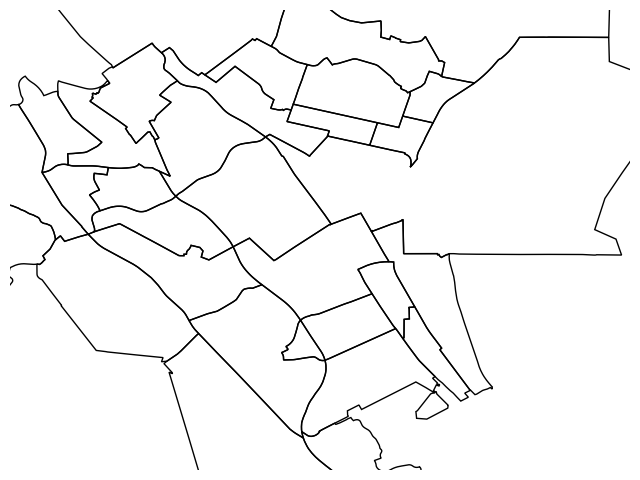

In [18]:
ax = gplt.polyplot(shapes)
gplt.kdeplot(metadata, n_levels=20, cmap='Reds', clip=shapes, ax=ax)

In [27]:
boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
collisions = gpd.read_file(gplt.datasets.get_path('nyc_collision_factors'))

In [29]:
boroughs.geometry = boroughs.geometry.map(lambda g: g.convex_hull)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

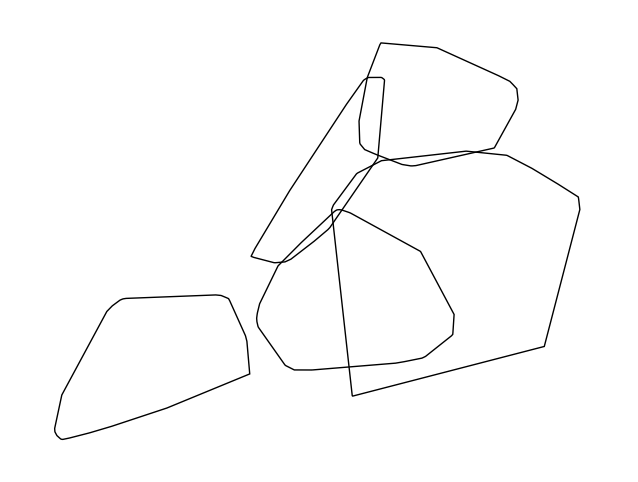

In [31]:
ax = gplt.polyplot(boroughs)
gplt.kdeplot(collisions, ax=ax, clip=boroughs)